# TP3 Robótica Movel

## Alunos
- Bernardo Nogueira Borges 2020006396
- Daniele Cassia Silva Diniz 2020076874

O objetivo deste trabalho prático é familiarizar o aluno com técnicas de exploração e mapeamento, onde
deverá ser implementado o algoritmo de Occupancy Grid. 

### Importando Libs

In [86]:
from collections import deque
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
from skimage.draw import line
import math
import matplotlib.pyplot as plt
import numpy as np

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

# Flag para evitar figuras nao utilizadas
CREATE_PLOTS = True

## Definição do robô
Você deve utilizar o robô diferencial Kobuki equipado com um laser. Esse robô é semelhante aos “robôs
aspiradores” tradicionais, e ele já está disponível nas cenas de simulação. Caso necessário, para
determinar o modelo cinemático, você pode obter algumas especificações técnicas do robô em:
https://yujinrobot.github.io/kobuki/enAppendixKobukiParameters.html
Valores testados em simulação e que tiveram bons resultados (mas que você pode/deve ajustar) são:
𝐿 = 0.230
𝑟 = 0.035

### Robô e Matrizes

In [87]:
# Iniciar o kobuki
robot = sim.getObject("/kobuki")
L = 0.230
r = 0.035

left_motor = sim.getObject("/kobuki/kobuki_leftMotor")
right_motor = sim.getObject("/kobuki/kobuki_rightMotor")

# Objetivo
goal_object = sim.getObject("/Goal")
sim.setObjectPosition(goal_object,sim.getObjectPosition(robot))

def getObjectXY(obj):
    *q, _ = sim.getObjectPosition(obj)
    return np.array(q[:2])

def getObjectAngle(obj):
    ori = sim.getObjectOrientation(obj)
    return ori[2]


## Occupancy Grid

### Criação do Grid

In [88]:
cell_size = 0.1
map_size = np.array([10, 10])
rows, cols = (map_size/cell_size).astype(int)
print(f"rows={rows} cols={cols}")
grid = np.full((rows, cols), 0.5)

rows=100 cols=100


### Conversão coordenandas grid - cena

In [89]:
def sceneToGrid(coords):
    sx, sy = coords
    gx = int((sx+5) / cell_size)
    gy = int((sy+5) / cell_size)
    return gx, gy


def gridToScene(coords):
    gx, gy = coords
    sx = (gx * cell_size) - 5 + (cell_size/2)
    sy = (gy * cell_size) - 5 + (cell_size/2)
    return sx, sy

### Interpretações dos valores do Grid

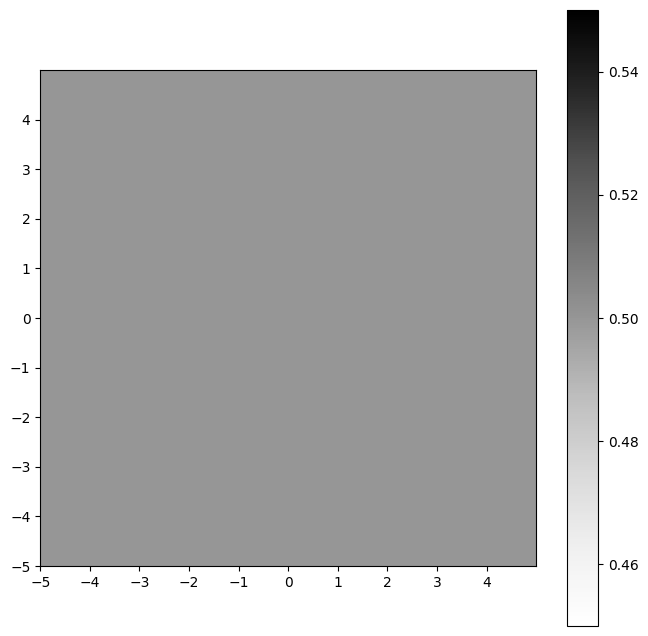

In [90]:
def out_of_bounds(x, y):
    return not (0 <= x < cols) and not (0 <= y < rows)

def show_occupancy_grid(plotname=None):
    fig = plt.figure(figsize=(8, 8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(grid, cmap='Greys', origin='lower', extent=(-5, 5, -5, 5))
    ax.set_xticks(np.arange(-5, 5, 1))
    ax.set_yticks(np.arange(-5, 5, 1))
    plt.colorbar()
    if plotname:
        plt.savefig(f"../images/{plotname}.png")
    plt.show()

if CREATE_PLOTS:
    show_occupancy_grid()

### Log-odds
$$l(A) = \log (o(A)) = log (\frac{p(A)}{p(\neg A)}) = log (\frac{p(A)}{1 - p(A)})$$

In [91]:
def log_odds(p):
    # Avoid division by zero
    if p < 0.0001:
        p = 0.0001
    if p > 0.9999:
        p = 0.9999
    return np.log(p/(1-p))


def inv_log_odds(lodd):
    return 1 - 1/(1 + np.exp(lodd))


l_occ = log_odds(0.85)
l_free = log_odds(0.1)

### Inverse Sensor Model

In [92]:
def inverse_sensor_model(xi, yi, xo, yo, z_t_k):
    r = math.sqrt((xi - xo)**2 + (yi - yo)**2)

    alpha = 0.2 / cell_size

    if r < (z_t_k - alpha):
        return l_free
    if r < (z_t_k + alpha):
        return l_occ

    # No info
    return grid[yo][xo]

### Occupancy Grid Mapping

In [93]:
def occupancy_grid_mapping(xo, yo, xf, yf):
    z_t = math.sqrt((xf - xo)**2 + (yf - yo)**2)
    rr, cc = line(xo, yo, xf, yf)
    for xi, yi in zip(rr, cc):
        if out_of_bounds(xi, yi):
            continue
        l_t = log_odds(grid[yi][xi])
        grid[yi][xi] = inv_log_odds(
            l_t + inverse_sensor_model(xi, yi, xo, yo, z_t))

## Fazendo Leituras
Para melhor visualizar a aplicabilidade da técnica, adicione um pequeno ruído
aleatório na leitura do laser, por exemplo, na distância medida e/ou ângulo de
leitura. Caso queira, você também pode variar o ruído e verificar qual o
impacto da qualidade do sensor no mapa final

In [94]:
def readSensorData():
    # ? Atualizacao da funcao simxGetStringSignal
    string_range_data = sim.getStringSignal("hokuyo_range_data")
    string_angle_data = sim.getStringSignal("hokuyo_angle_data")

    # Verifica se os dados foram obtidos corretamente
    if string_range_data == None or string_angle_data == None:
        return None

    # unpack dos dados de range e angulos do sensor
    raw_range_data = sim.unpackFloatTable(string_range_data)
    raw_angle_data = sim.unpackFloatTable(string_angle_data)
    return raw_range_data, raw_angle_data


def getLaserData():
    # Em loop até garantir que as leituras serão válidas
    sensor_data = readSensorData()
    while sensor_data == None:
        sensor_data = readSensorData()

    raw_range_data, raw_angle_data = sensor_data
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    return laser_data


def robotLaserTransformationMatrix():
    obj = sim.getObject("/fastHokuyo")
    M = sim.getObjectMatrix(obj, robot)
    M = np.array(M).reshape(-1, 4)
    return M


MAX_SENSOR_RANGE = 5.0


def getObstaclePositions(laser_data):
    # Matriz de transformação laser -> robô
    Trl = robotLaserTransformationMatrix()
    Trl = np.vstack([Trl, [0, 0, 0, 1]])
    # Matriz de transformação robô -> mundo
    Twr = sim.getObjectMatrix(robot)
    Twr = np.vstack([np.array(Twr).reshape(3, 4), [0, 0, 0, 1]])

    def in_range(laser_read):
        _, dist = laser_read
        return dist <= MAX_SENSOR_RANGE - 0.1

    obs = filter(in_range, laser_data)

    # ? Adicionar ruido ao sensor
    def add_noise(laser_read):
        ang, dist = laser_read
        noise = np.random.normal(0, 0.05)
        return (ang, dist+noise)

    obs = map(add_noise, obs)

    def laser_read_to_point(laser_read):
        ang, dist = laser_read
        x = dist * np.cos(ang)
        y = dist * np.sin(ang)
        Pl = np.array([x, y, 0, 1])
        Pr = Trl @ Pl
        Pw = Twr @ Pr
        return np.array([Pw[0], Pw[1]])

    obs = map(laser_read_to_point, obs)

    def in_scene(coords):
        x, y = coords
        # Coordenadas limites da cena: -5, 5
        return -5 <= x <= 5 and -5 <= y <= 5

    return list(filter(in_scene, obs))

# TODO


def draw_laser_data(laser_data, ax):
    q_obs = getObstaclePositions(laser_data)
    for x, y in q_obs:
        ax.plot(x, y, 'o', color='g')

## Navegação Reativa - Campos Potenciais

### Força de Atração
$$f_{att}(q) = k_{att} \cdot (q_{goal} - q)$$

In [95]:
def ForceAttraction(q, q_goal, katt=0.1):
    return katt * (q_goal - q)

### Força de repulsão
$$F_{rep,i}(q) = -\nabla U_{rep,i}(q)$$
$$=\begin{cases}
  \begin{aligned}
    \frac{k_{rep,i}}{\rho_i^2(q)}\left( \frac{1}{\rho_i(q)} - \frac{1}{\rho_{0,i}} \right)^{\gamma-1} \frac{q - q_{obs,i}}{\rho_i(q)} &, \textnormal{se } \rho_i(q) \le \rho_{0,i}\\
    0&, \textnormal{se } \rho_i(q) \gt \rho_{0,i}\\
  \end{aligned}
\end{cases}
$$


In [96]:
LIMIT_RANGE = 0.3

def ForceRepulsion(q, q_obs_i, krep=.0005):
    d = np.linalg.norm(q - q_obs_i)
    if d > LIMIT_RANGE:
        return np.array([0.0,0.0])
    return (krep / d**2) * ((1/d) - (1/LIMIT_RANGE)) * (q-q_obs_i) / d

### Força Resultante 
$$F(q)  = F_{att}(q) + \sum_{i=1}^{p}{F_{rep,i}(q)}$$

In [97]:
def ForceResult(q,q_goal,q_obs):
    ans = ForceAttraction(q,q_goal) 
    for i in range(len(q_obs)):
        ans += ForceRepulsion(q,q_obs[i])
    return ans

### Controladores
- [De Luca e Oriolo, 1994](https://www.researchgate.net/publication/225543929_Control_of_Wheeled_Mobile_Robots_An_Experimental_Overview)
$$v = k_v(\dot x \cos \theta + \dot y \sin \theta)$$
$$\omega = k_{\omega}(atan2(\dot y,\dot x) - \theta)$$
$$u = \begin{bmatrix}
   v \\
   \omega 
\end{bmatrix}
$$

In [98]:
def deLucaOriolo(force, theta):
    kv = 1
    kw = .7
    Fx, Fy = force
    v = kv*(Fx*np.cos(theta) + Fy*np.sin(theta))
    w = kw*(np.arctan2(Fy, Fx) - theta)
    return [v, w]

### Modelo Cinemático - Robô Diferencial
$$\omega_R = \frac{2v+\omega L}{2r}$$
$$\omega_L = \frac{2v-\omega L}{2r}$$

In [99]:
def differentialModel(v, w):
    wr = ((2.0*v) + (w*L))/(2.0*r)
    wl = ((2.0*v) - (w*L))/(2.0*r)
    return [wl, wr]

## Movendo o robô
O aluno também deverá propor uma
estratégia de navegação para que o robô explore o ambiente construindo o mapa. Essa estratégia pode
ser simples e baseada nos algoritmos vistos em aula. 

### Controle Diferencial

In [100]:
def perform_control(q,q_goal):
    laser_data = getLaserData()
    q_obs = getObstaclePositions(laser_data)
    force = ForceResult(q,q_goal,q_obs) 
    
    theta = getObjectAngle(robot)
    # Controle Cinematico
    [v,w] = deLucaOriolo(force,theta)
    # Cinematica inversa
    [wl,wr] = differentialModel(v,w)
    # Enviando velocidades
    sim.setJointTargetVelocity(left_motor,wl)
    sim.setJointTargetVelocity(right_motor,wr)

### Simulacao

In [101]:

def runSimulation(known_goals, MAX_SIMULATION_TIME=300,RECORD_PLOT=False):

    sim.stopSimulation()
    sim.startSimulation()

    read_cnt = 0
    goal_idx = 0
    ngx, ngy = known_goals[goal_idx]
    sim.setObjectPosition(goal_object, [ngx, ngy, 0])

    # Recording points
    robot_xs = []
    robot_ys = []
    seen_points = set()

    while (t := sim.getSimulationTime()) < MAX_SIMULATION_TIME:
        q = getObjectXY(robot)
        q_goal = getObjectXY(goal_object)

        error = np.linalg.norm(q_goal - q)
        if error < 0.3:
            print(f"Goal reached: {known_goals[goal_idx]}")
            goal_idx += 1

            # End of track
            if goal_idx >= len(known_goals):
                break

            ngx, ngy = known_goals[goal_idx]
            sim.setObjectPosition(goal_object, [ngx, ngy, 0])

        # Calcular Occupancy Grid
        read_cnt += 1
        if read_cnt == 20:
            read_cnt = 0
            # Pontos de obstaculo na cena
            xo, yo = sceneToGrid(q)
            laser_data = getLaserData()
            obstacles = getObstaclePositions(laser_data)

            # Para cada obstaculo, atualizar occupancy
            for sx, sy in obstacles:
                if RECORD_PLOT:
                    seen_points.add((round(sx, 1), round(sy, 1)))
                xf, yf = sceneToGrid((sx, sy))
                occupancy_grid_mapping(xo, yo, xf, yf)

        perform_control(q, q_goal)

        if RECORD_PLOT:
            robot_xs.append(q[0])
            robot_ys.append(q[1])
        sim.step()

    # Stop
    sim.setJointTargetVelocity(left_motor, 0)
    sim.setJointTargetVelocity(right_motor, 0)
    sim.stopSimulation()

    return robot_xs,robot_ys, seen_points

def create_incremental_plot(robot_xs,robot_ys,seen_points,testname=None):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.set_aspect('equal')
    for sx, sy in seen_points:
        ax.plot(sx, sy, marker='s', color='black')
    ax.grid()
    ax.plot(robot_xs,robot_ys)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    if testname != None:
        plt.savefig(f"../images/plot-{testname}.png")
    


## Testes

Goal reached: (-0.75, 3)
Goal reached: (-0.75, 2)
Goal reached: (-0.75, 0.9)
Goal reached: (-4.5, 0.4)
Goal reached: (-4.5, -1.6)
Goal reached: (-2.75, -1.65)
Goal reached: (-2.85, -4.5)
Goal reached: (-0.5, -4.6)
Goal reached: (-0.5, -1.5)
Goal reached: (0.7, 0.3)
Goal reached: (0.75, 3.5)
Goal reached: (2.5, 1.5)
Goal reached: (3.5, -0.8)
Goal reached: (3.8, -4.2)


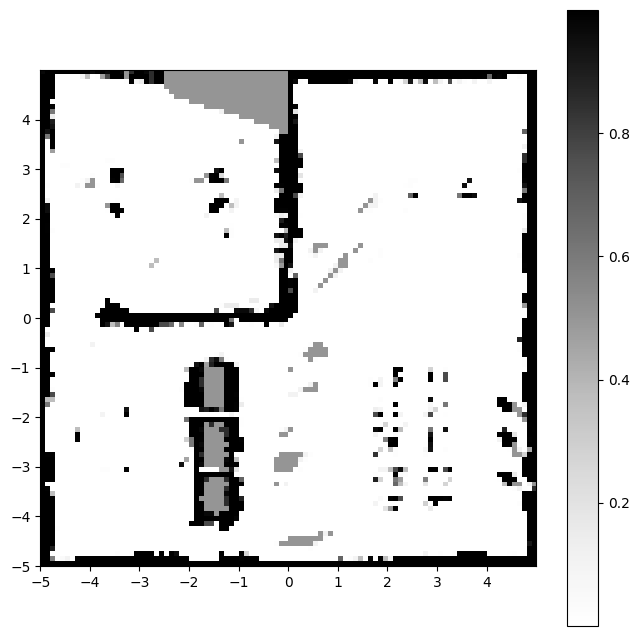

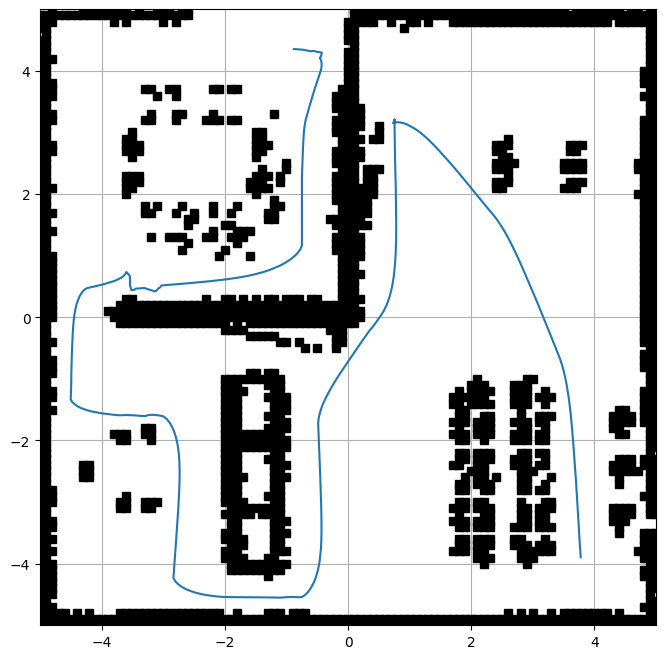

In [102]:
TEST_NUMBER = 1


# Test 1
if TEST_NUMBER == 1:
    sim.setObjectPosition(robot, [-0.881, 4.355, 0])
    known_goals = [
        (-0.75, 3),
        (-0.75, 2),
        (-0.75, 0.9),
        (-4.5, 0.4),
        (-4.5, -1.6),
        (-2.75, -1.65),
        (-2.85, -4.5),
        (-0.5, -4.6),
        (-0.5, -1.5),
        (0.7, 0.3),
        (0.75, 3.5),
        (2.5, 1.5),
        (3.5, -0.8),
        (3.8, -4.2)
    ]

else:
    sim.setObjectPosition(robot, [3.3, 4, 0])
    known_goals = [
        (3,4),
        (1,3.8),
        (1.1,0.5),
        (1.0,-4.6),
        (-1.0,-4.6),
        (-4.5,-4.0)
    ]

rxs,rys,sps=runSimulation(known_goals,RECORD_PLOT=True)
show_occupancy_grid()
create_incremental_plot(rxs,rys,sps)